In [1]:
import jax.numpy as jnp
import bayes3d as b
import trimesh
import os
import numpy as np
import trimesh
import jax


# --- creating the model dir from the working directory
model_dir = os.path.join(j.utils.get_assets_dir(), "ycb_video_models/models")
print(f"{model_dir} exists: {os.path.exists(model_dir)}")
model_names = j.ycb_loader.MODEL_NAMES
IDX = 13
name = model_names[IDX]
print(name)


bop_ycb_dir = os.path.join(j.utils.get_assets_dir(), "bop/ycbv")
rgbd, gt_ids, gt_poses, masks = j.ycb_loader.get_test_img('52', '1', bop_ycb_dir)
intrinsics = j.Intrinsics(
    height=rgbd.intrinsics.height,
    width=rgbd.intrinsics.width,
    fx=rgbd.intrinsics.fx, fy=rgbd.intrinsics.fx,
    cx=rgbd.intrinsics.width/2.0, cy=rgbd.intrinsics.height/2.0,
    near=0.001, far=2.0
)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
/home/ubuntu/jax3dp3/assets/ycb_video_models/models exists: True
025_mug


In [2]:
import bayes3d.posecnn_densefusion
densefusion = jax3dp3.posecnn_densefusion.DenseFusion()

/home/ubuntu/jax3dp3/jax3dp3/posecnn-pytorch/PoseCNN-PyTorch
adding /home/ubuntu/jax3dp3/jax3dp3/posecnn-pytorch/PoseCNN-PyTorch/tools/.. to path
adding /home/ubuntu/jax3dp3/jax3dp3/posecnn-pytorch/PoseCNN-PyTorch/tools/../lib to path
adding /home/ubuntu/jax3dp3/jax3dp3/posecnn-pytorch/PoseCNN-PyTorch/tools/../ycb_render to path
ycb_video_train
ycb_video_val
ycb_video_keyframe
ycb_video_trainval
ycb_video_debug
ycb_object_train
ycb_object_test
ycb_self_supervision_train_1
ycb_self_supervision_train_2
ycb_self_supervision_train_3
ycb_self_supervision_train_4
ycb_self_supervision_train_5
ycb_self_supervision_test
ycb_self_supervision_all
ycb_self_supervision_train_block_median
ycb_self_supervision_train_block_median_azure
ycb_self_supervision_train_block_median_demo
ycb_self_supervision_train_block_median_azure_demo
ycb_self_supervision_train_table
ycb_self_supervision_debug
ycb_self_supervision_train_block
ycb_self_supervision_train_block_azure
ycb_self_supervision_train_block_big_sim
y

/home/ubuntu/jax3dp3/jax3dp3/posecnn-pytorch/PoseCNN-PyTorch/tools/../lib/densefusion/transformations.py:1912: UserWarning: failed to import module _transformations
  warnings.warn('failed to import module %s' % name)
/opt/conda/envs/jax/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/jax/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


resetting to seed 100
Called with args:
{'gpu_id': 0, 'pretrained': '/home/ubuntu/jax3dp3/jax3dp3/posecnn-pytorch/PoseCNN-PyTorch/data/trained_checkpoints/posecnn/ycb_object/vgg16_ycb_object_self_supervision_epoch_8.checkpoint.pth', 'cfg_file': '/home/ubuntu/jax3dp3/jax3dp3/posecnn-pytorch/PoseCNN-PyTorch/experiments/cfgs/ycb_object.yml', 'dataset_name': 'ycb_object_test', 'datadir': '/home/ubuntu/jax3dp3/jax3dp3/posecnn-pytorch/PoseCNN-PyTorch/datasets/pandas/data/new_panda/', 'resdir': '/home/ubuntu/jax3dp3/jax3dp3/posecnn-pytorch/PoseCNN-PyTorch/datasets/pandas/data/results_PoseCNN_pandas/', 'network_name': 'posecnn', 'background_name': None, 'meta_file': None, 'pretrained_encoder': None, 'codebook': None}
Using config:
{'ANCHOR_RATIOS': [0.5, 1, 2],
 'ANCHOR_SCALES': [8, 16, 32],
 'BACKGROUND': '',
 'CAD': '',
 'DATA_PATH': '',
 'EPS': 1e-14,
 'EXP_DIR': 'ycb_object',
 'FEATURE_STRIDE': 16,
 'FLIP_X': False,
 'FLOW_HEIGHT': 512,
 'FLOW_WIDTH': 640,
 'GPU_ID': 0,
 'INPUT': 'COLOR',


In [3]:
mesh_path = os.path.join(model_dir,name,"textured.obj")
print(mesh_path)
mesh = j.mesh.load_mesh(mesh_path)

/home/ubuntu/jax3dp3/assets/ycb_video_models/models/025_mug/textured.obj


In [6]:
NUM_IMAGES_PER_ITER = 5
FIXED_TRANSLATION = jnp.array([0.0, 0.08324493, 1.0084537])
_seed = 1222
key = jax.random.PRNGKey(_seed) 
object_poses = jax.vmap(lambda key: j.distributions.gaussian_vmf(key, 0.00001, 0.001))(
    jax.random.split(key, NUM_IMAGES_PER_ITER)
)
object_poses = object_poses.at[:,:3,3].set(FIXED_TRANSLATION)

INFO:kubric.renderer.blender:Using scratch rendering folder: '/tmp/tmpt_30t2ae'


path:
/home/ubuntu/jax3dp3
sudo docker run --rm --interactive --user $(id -u):$(id -g) --volume /home/ubuntu/jax3dp3:/home/ubuntu/jax3dp3 --volume /tmp:/tmp   --volume /home/ubuntu/jax3dp3/assets/ycb_video_models/models/025_mug:/home/ubuntu/jax3dp3/assets/ycb_video_models/models/025_mug  kubricdockerhub/kubruntu /usr/bin/python3 /home/ubuntu/jax3dp3/jax3dp3/photorealistic_renderers/kubric_exec_parallel.py
['/home/ubuntu/jax3dp3/assets/ycb_video_models/models/025_mug/textured.obj']
POSES: [[[array([0.        , 0.08324493, 1.0084537 ], dtype=float32)
   array([ 0.00121348,  0.46153274,  0.84523565, -0.26937476], dtype=float32)]]

 [[array([0.        , 0.08324493, 1.0084537 ], dtype=float32)
   array([ 0.34542915,  0.7106736 , -0.06142811, -0.60979384], dtype=float32)]]

 [[array([0.        , 0.08324493, 1.0084537 ], dtype=float32)
   array([ 0.3619423 ,  0.01465584, -0.65747994,  0.6606838 ], dtype=float32)]]

 [[array([0.        , 0.08324493, 1.0084537 ], dtype=float32)
   array([ 0.558

INFO:kubric.renderer.blender:Rendered frame '/tmp/tmpt_30t2ae/images/frame_0001.png'


RENDERED FRAME 
SAVED FRAME USING NP


INFO:kubric.renderer.blender:Using scratch rendering folder: '/tmp/tmpqo0l7mpl'
INFO:kubric.renderer.blender:Using scratch rendering folder: '/tmp/tmpoavcms7f'
INFO:kubric.renderer.blender:Rendered frame '/tmp/tmpqo0l7mpl/images/frame_0001.png'


RENDERED FRAME 
SAVED FRAME USING NP


INFO:kubric.renderer.blender:Rendered frame '/tmp/tmpoavcms7f/images/frame_0001.png'


RENDERED FRAME 
SAVED FRAME USING NP


INFO:kubric.renderer.blender:Using scratch rendering folder: '/tmp/tmphbroadmy'
INFO:kubric.renderer.blender:Using scratch rendering folder: '/tmp/tmpo4v9vg6q'
INFO:kubric.renderer.blender:Rendered frame '/tmp/tmphbroadmy/images/frame_0001.png'


RENDERED FRAME 
SAVED FRAME USING NP


INFO:kubric.renderer.blender:Rendered frame '/tmp/tmpo4v9vg6q/images/frame_0001.png'


RENDERED FRAME 
SAVED FRAME USING NP


INFO:kubric.renderer.blender:Using scratch rendering folder: '/tmp/tmpr6f0pdyd'
INFO:kubric.renderer.blender:Rendered frame '/tmp/tmpr6f0pdyd/images/frame_0001.png'
INFO:kubric.renderer.blender:Using scratch rendering folder: '/tmp/tmp2tpvg14u'


RENDERED FRAME 
SAVED FRAME USING NP


INFO:kubric.renderer.blender:Rendered frame '/tmp/tmp2tpvg14u/images/frame_0001.png'


RENDERED FRAME 
SAVED FRAME USING NP


INFO:kubric.renderer.blender:Using scratch rendering folder: '/tmp/tmp1n59t0j0'
INFO:kubric.renderer.blender:Rendered frame '/tmp/tmp1n59t0j0/images/frame_0001.png'
INFO:kubric.renderer.blender:Using scratch rendering folder: '/tmp/tmphw6a2hhk'


RENDERED FRAME 
SAVED FRAME USING NP


INFO:kubric.renderer.blender:Rendered frame '/tmp/tmphw6a2hhk/images/frame_0001.png'


RENDERED FRAME 
SAVED FRAME USING NP


INFO:kubric.renderer.blender:Using scratch rendering folder: '/tmp/tmp0s6mvsbt'
INFO:kubric.renderer.blender:Rendered frame '/tmp/tmp0s6mvsbt/images/frame_0001.png'
INFO:kubric.renderer.blender:Using scratch rendering folder: '/tmp/tmpsml9pxzh'


RENDERED FRAME 
SAVED FRAME USING NP
Error: Not freed memory blocks: 5, total unfreed memory 0.006294 MB


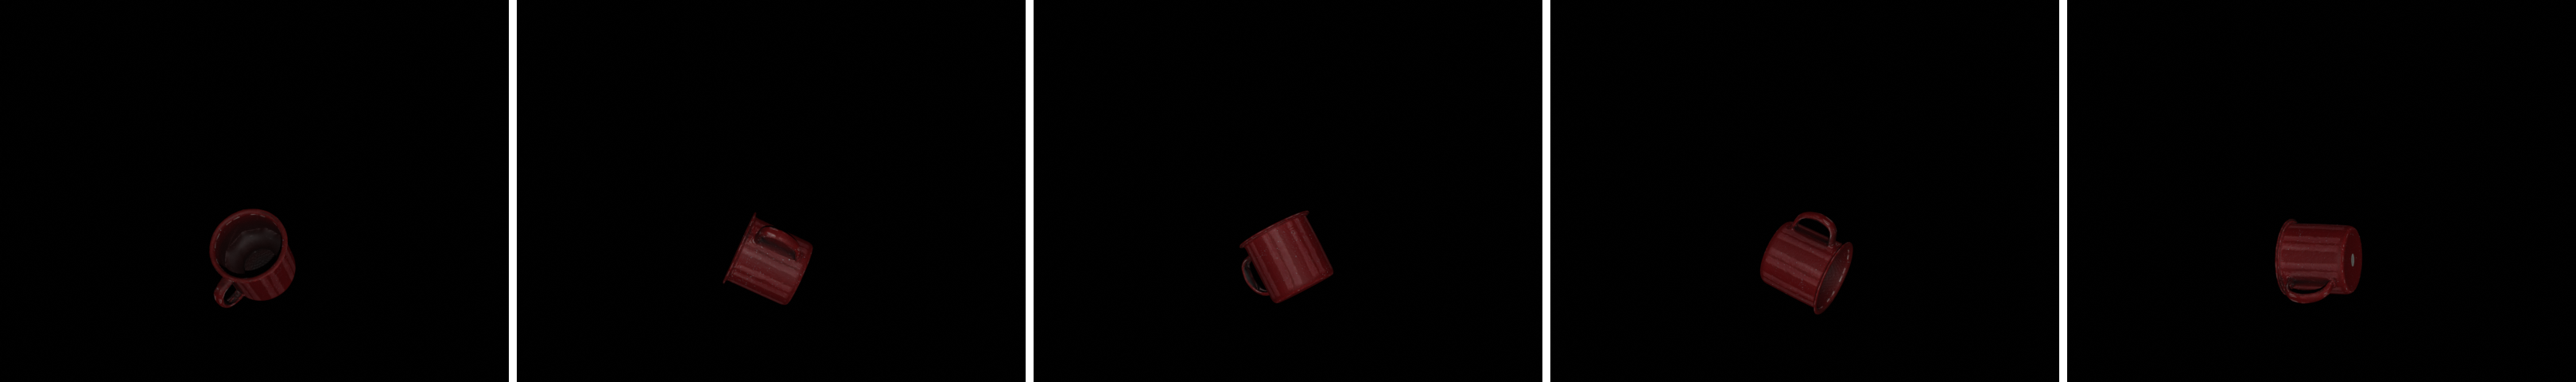

INFO:kubric.renderer.blender:Rendered frame '/tmp/tmpsml9pxzh/images/frame_0001.png'


RENDERED FRAME 
SAVED FRAME USING NP


In [7]:
## fetch dataset
DATASET_FILENAME = f"dataset_{_seed}_{NUM_IMAGES_PER_ITER}.npz"  # npz file
DATASET_FILE = os.path.join(j.utils.get_assets_dir(), f"datasets/{DATASET_FILENAME}")

load_from_existing = False

# generate and save the dataset
if not load_from_existing:
    rgbds = j.kubric_interface.render_multiobject_parallel([mesh_path], object_poses[None,...],
                                                          intrinsics, scaling_factor=1.0, lighting=1.0) # multi img singleobj
    np.savez(DATASET_FILE, rgbds=rgbds, poses=object_poses, id=IDX, name=model_names[IDX], intrinsics=intrinsics, mesh_path=mesh_path)

# or load preexisting dataset
else:
    data = np.load(DATASET_FILE,allow_pickle=True)
    rgbds = data["rgbds"]
    object_poses = data["poses"]
    id = data["id"].item()

rgb_images = j.hvstack_images([j.get_rgb_image(r.rgb) for r in rgbds], 1, 5)
rgb_images.show()
rgb_images.save(f"dataset_{NUM_IMAGES_PER_ITER}_seed_{_seed}.png")



 Running models on 0..
PoseCNN: entering test_image
object 0, class 025_mug, z 0.6668890118598938, z new 1.0511109828948975
sdf 7355 points for object 0, class 13 025_mug
sdf with 7355 points
sdf refinement iterations 50, time 0.074253
pose refine time 0.167623
025_mug 0.7537117 13


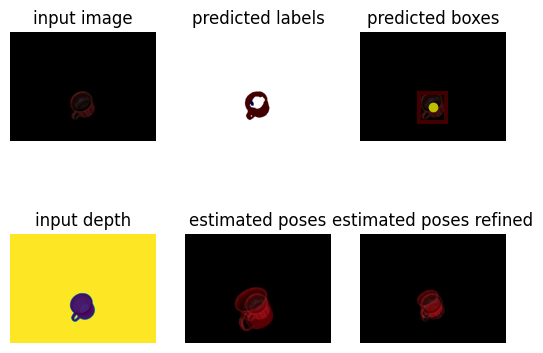

Saving img...
PoseCNN: Finished test_image

 Running dense fusion models on 0..
****************Processing 0*******************
refining for 10000 iterations
******Loading posecnn results from current run******
025_mug


/opt/conda/envs/jax/lib/python3.8/site-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/opt/conda/envs/jax/lib/python3.8/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
INFO:kubric.renderer.blender:Using scratch rendering folder: '/tmp/tmp9f2xt8jq'
INFO:kubric.renderer.blender:Rendered frame '/tmp/tmp9f2xt8jq/images/frame_0001.png'


RENDERED FRAME 
SAVED FRAME USING NP


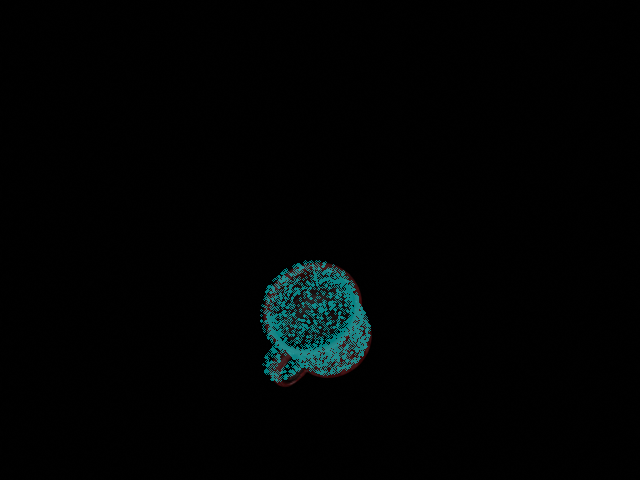


 saved results to /home/ubuntu/jax3dp3/experiments/kubric_dataset_gen/Densefusion_iterative_result

Finish 0 keyframe

 Running models on 1..
PoseCNN: entering test_image
object 0, class 025_mug, z 0.6147094368934631, z new 1.0312224626541138
sdf 4580 points for object 0, class 13 025_mug
sdf with 4580 points
sdf refinement iterations 50, time 0.037127
pose refine time 0.045717
025_mug 0.84923697 13


<Figure size 640x480 with 0 Axes>

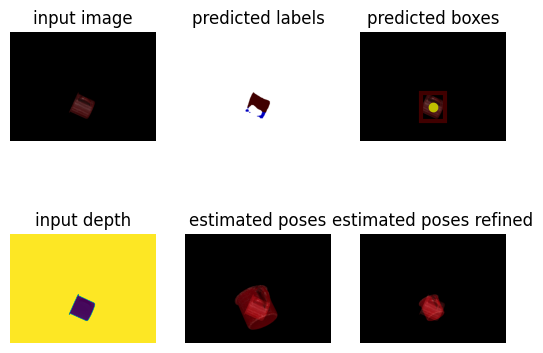

Saving img...
PoseCNN: Finished test_image

 Running dense fusion models on 1..
****************Processing 1*******************
refining for 10000 iterations
******Loading posecnn results from current run******
025_mug


INFO:kubric.renderer.blender:Using scratch rendering folder: '/tmp/tmpm5zfg23p'
INFO:kubric.renderer.blender:Rendered frame '/tmp/tmpm5zfg23p/images/frame_0001.png'


RENDERED FRAME 
SAVED FRAME USING NP


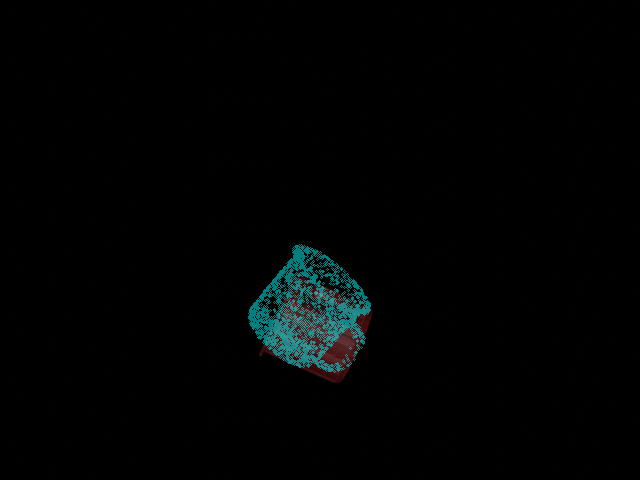


 saved results to /home/ubuntu/jax3dp3/experiments/kubric_dataset_gen/Densefusion_iterative_result

Finish 1 keyframe

 Running models on 2..
PoseCNN: entering test_image
object 0, class 025_mug, z 0.6724629402160645, z new 1.0719056129455566
sdf 2314 points for object 0, class 13 025_mug
sdf with 2314 points
sdf refinement iterations 50, time 0.046024
pose refine time 0.061675
025_mug 0.5045455 13


<Figure size 640x480 with 0 Axes>

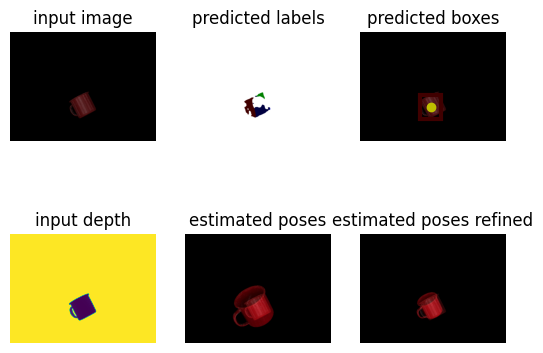

Saving img...
PoseCNN: Finished test_image

 Running dense fusion models on 2..
****************Processing 2*******************
refining for 10000 iterations
******Loading posecnn results from current run******
025_mug


INFO:kubric.renderer.blender:Using scratch rendering folder: '/tmp/tmpx1te384l'
INFO:kubric.renderer.blender:Rendered frame '/tmp/tmpx1te384l/images/frame_0001.png'


RENDERED FRAME 
SAVED FRAME USING NP


INFO:kubric.renderer.blender:Using scratch rendering folder: '/tmp/tmpmg8rhrlz'


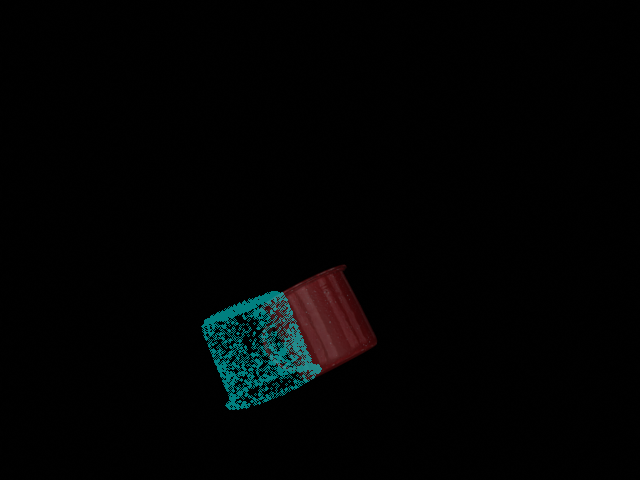


 saved results to /home/ubuntu/jax3dp3/experiments/kubric_dataset_gen/Densefusion_iterative_result

Finish 2 keyframe

 Running models on 3..
PoseCNN: entering test_image
object 0, class 025_mug, z 0.6622132062911987, z new 1.0873671770095825
sdf 3940 points for object 0, class 13 025_mug
sdf with 3940 points
sdf refinement iterations 50, time 0.041200
pose refine time 0.051853
025_mug 0.90501845 13


<Figure size 640x480 with 0 Axes>

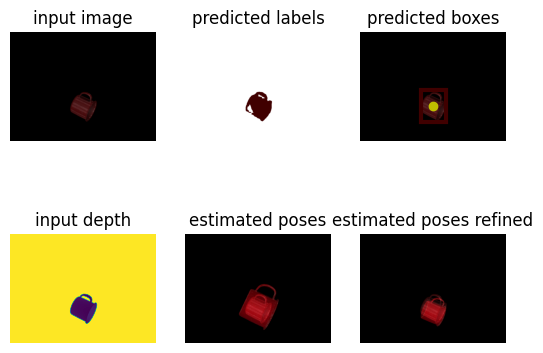

Saving img...
PoseCNN: Finished test_image

 Running dense fusion models on 3..
****************Processing 3*******************
refining for 10000 iterations
******Loading posecnn results from current run******
025_mug


INFO:kubric.renderer.blender:Rendered frame '/tmp/tmpmg8rhrlz/images/frame_0001.png'


RENDERED FRAME 
SAVED FRAME USING NP


INFO:kubric.renderer.blender:Using scratch rendering folder: '/tmp/tmp7gde_aps'


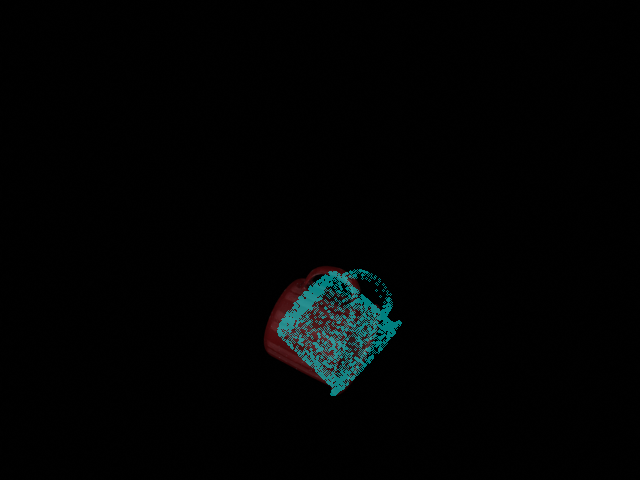


 saved results to /home/ubuntu/jax3dp3/experiments/kubric_dataset_gen/Densefusion_iterative_result

Finish 3 keyframe

 Running models on 4..
PoseCNN: entering test_image
object 0, class 025_mug, z 0.6303223371505737, z new 1.0564491748809814
sdf 9475 points for object 0, class 13 025_mug
sdf with 9475 points
sdf refinement iterations 50, time 0.050773
pose refine time 0.062799
025_mug 0.9605771 13


<Figure size 640x480 with 0 Axes>

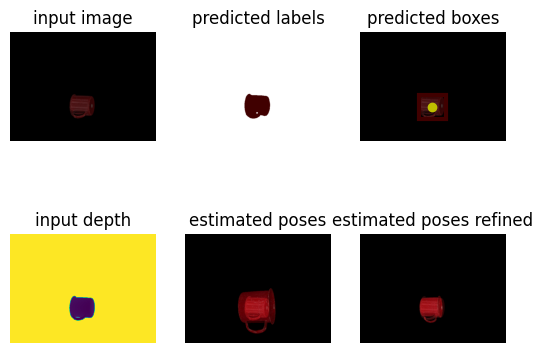

Saving img...
PoseCNN: Finished test_image

 Running dense fusion models on 4..
****************Processing 4*******************
refining for 10000 iterations
******Loading posecnn results from current run******
025_mug


INFO:kubric.renderer.blender:Rendered frame '/tmp/tmp7gde_aps/images/frame_0001.png'


RENDERED FRAME 
SAVED FRAME USING NP


INFO:kubric.renderer.blender:Using scratch rendering folder: '/tmp/tmp6sf3mjqy'


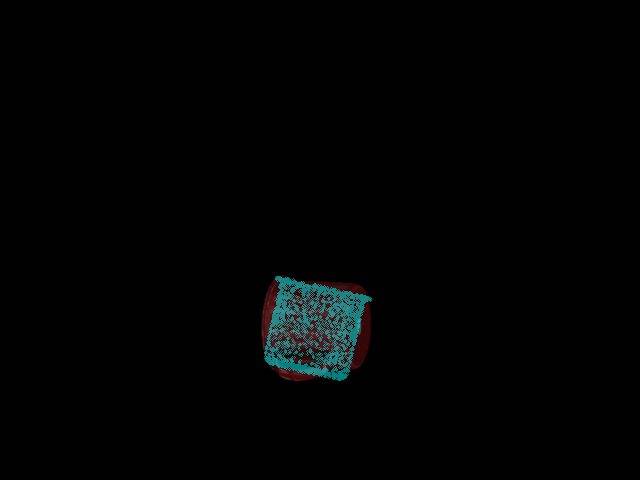


 saved results to /home/ubuntu/jax3dp3/experiments/kubric_dataset_gen/Densefusion_iterative_result

Finish 4 keyframe


<Figure size 640x480 with 0 Axes>

In [8]:
# run densefusion on dataset
all_results = []
for scene_idx, rgbd in enumerate(rgbds):
    results = densefusion.get_densefusion_results(rgbd.rgb, rgbd.depth, rgbd.intrinsics, scene_name=str(scene_idx))
    all_results.extend(results)

In [11]:
# process densefusion results
import pickle
with open(f"dataset_{NUM_IMAGES_PER_ITER}_seed_{_seed}.pkl", 'wb') as f:
    pickle.dump(all_results, f)

translation_err = jnp.zeros((1,3))
for results in all_results:
    pred_rot = results[name]['rot_q']
    pred_transl = results[name]['tr']
    translation_err += pred_transl

avg_translation_err = translation_err / len(all_results)
avg_translation_err

[{'025_mug': {'class_id': 14, 'rot_q': array([ 0.02888059, -0.4260505 , -0.86835563,  0.25220107]), 'tr': array([-0.00241143,  0.08130644,  1.01351431])}}, {'025_mug': {'class_id': 14, 'rot_q': array([0.59954498, 0.66970422, 0.4301595 , 0.08369514]), 'tr': array([-0.01254528,  0.06909672,  1.01036152])}}, {'025_mug': {'class_id': 14, 'rot_q': array([ 0.47726329, -0.60201228, -0.3164398 , -0.55647715]), 'tr': array([-0.0578148 ,  0.09705482,  0.98528692])}}, {'025_mug': {'class_id': 14, 'rot_q': array([ 0.63361846, -0.58526483,  0.50012484, -0.07660206]), 'tr': array([0.01605609, 0.08085801, 1.00555971])}}, {'025_mug': {'class_id': 14, 'rot_q': array([ 0.65981436,  0.53442968,  0.42320673, -0.31611073]), 'tr': array([-0.00486059,  0.08655128,  1.01325254])}}]


Array([[-0.0123152 ,  0.08297346,  1.0055951 ]], dtype=float32)

INFO:kubric.renderer.blender:Using scratch rendering folder: '/tmp/tmpm2wt12nt'


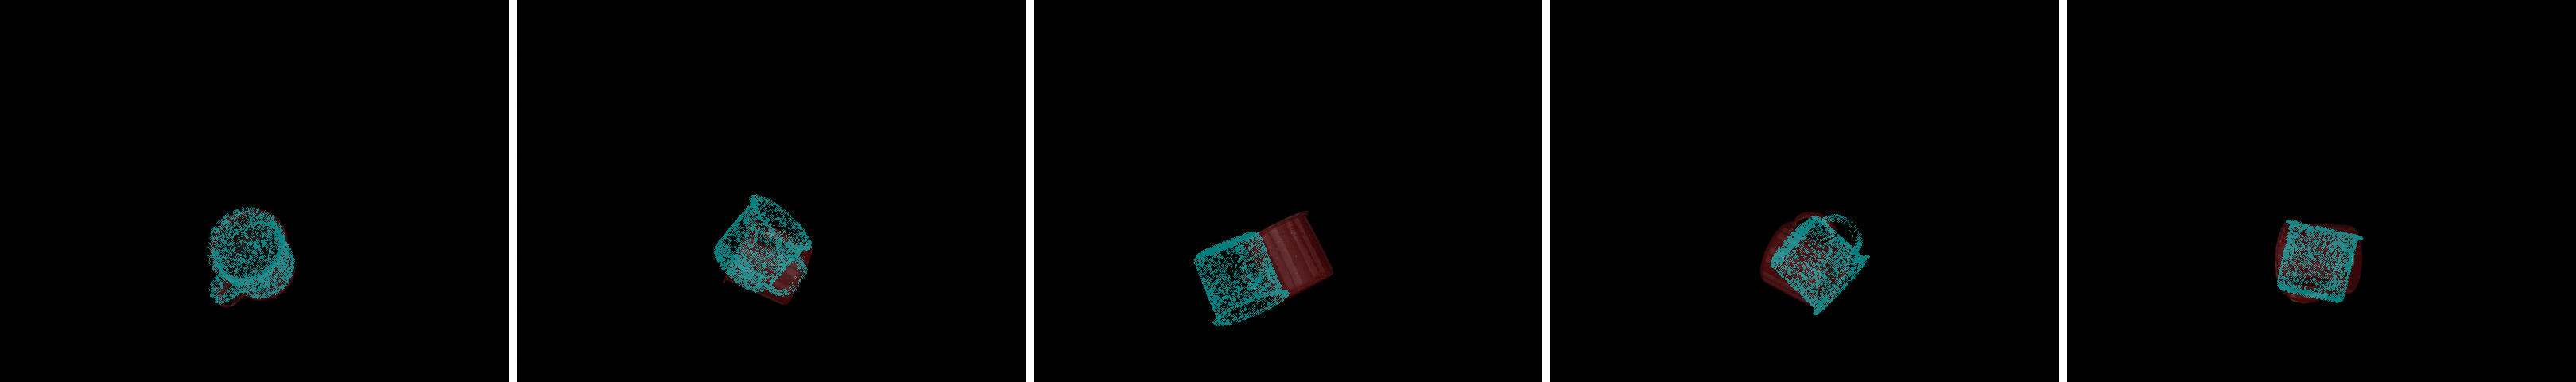

INFO:kubric.renderer.blender:Rendered frame '/tmp/tmpm2wt12nt/images/frame_0001.png'


RENDERED FRAME 
SAVED FRAME USING NP


INFO:kubric.renderer.blender:Using scratch rendering folder: '/tmp/tmpm3ot5e8r'


In [12]:
## Visualize densefusion outputs

from PIL import Image

VIZ_DIR = os.path.join(os.getcwd(), "Densefusion_iterative_result/")

densefusion_vizs = []

for scene_idx, _ in enumerate(rgbds):
    im = Image.open(os.path.join(VIZ_DIR, f"{scene_idx}.png"))
    densefusion_vizs.append(im)
densefusion_result_viz = j.hvstack_images(densefusion_vizs, 1, 5)
densefusion_result_viz.show()

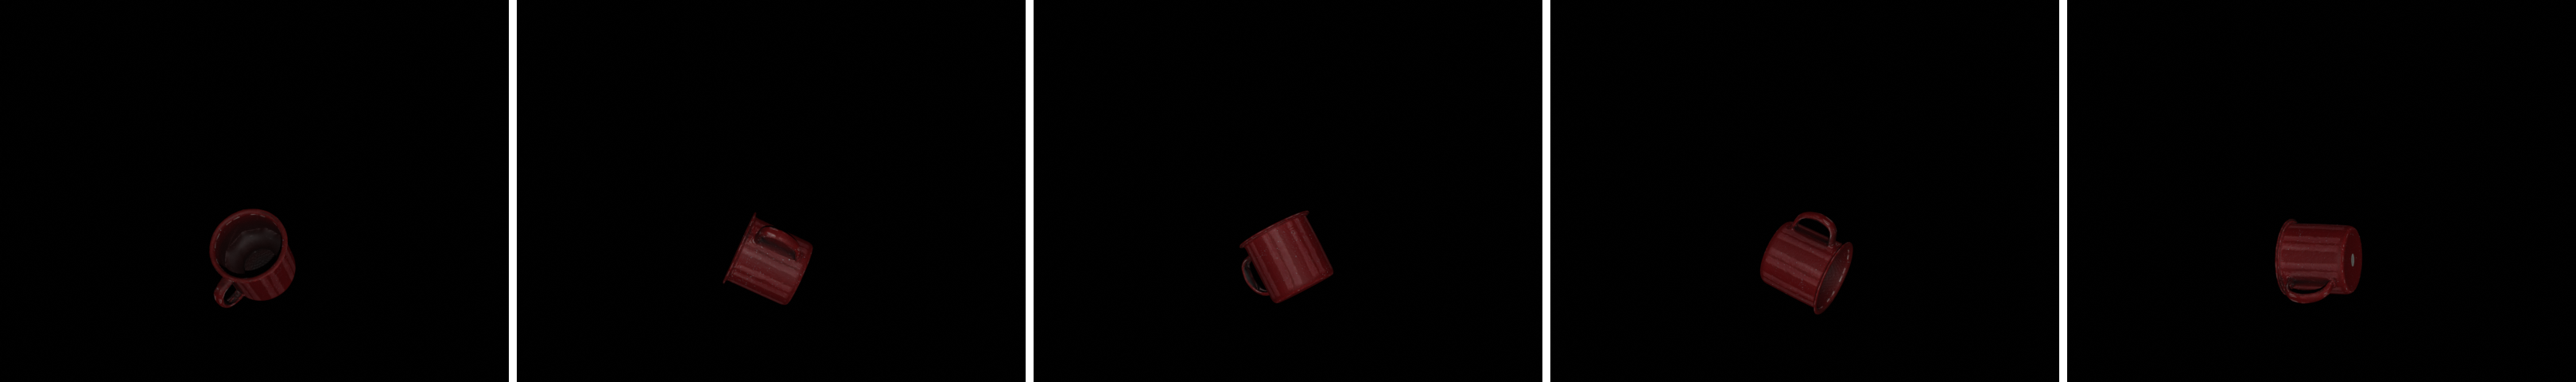

INFO:kubric.renderer.blender:Rendered frame '/tmp/tmpm3ot5e8r/images/frame_0001.png'


RENDERED FRAME 
SAVED FRAME USING NP


INFO:kubric.renderer.blender:Using scratch rendering folder: '/tmp/tmp_p0cu_w3'
INFO:kubric.renderer.blender:Rendered frame '/tmp/tmp_p0cu_w3/images/frame_0001.png'


RENDERED FRAME 
SAVED FRAME USING NP


In [13]:
rgb_images.show()  # original dataset for comparison